In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data 
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def get_inputs(real_size, noise_size):
    
    real_img = tf.placeholder(tf.float32, [None, real_size])
    noise_img = tf.placeholder(tf.float32, [None, noise_size])
    
    return real_img, noise_img

In [6]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
  
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

In [7]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):

    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

In [8]:
img_size = mnist.train.images[0].shape[0]

noise_size = 100

g_units = 128

d_units = 128

learning_rate = 0.001

alpha = 0.01

In [9]:
tf.reset_default_graph()

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)

In [10]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))

In [11]:
train_vars = tf.trainable_variables()

# generator
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [12]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        train_loss_d = sess.run(d_loss, 
                                feed_dict = {real_img: batch_images, 
                                             noise_img: batch_noise})
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, 
                                     feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, 
                                    feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # generator loss
        train_loss_g = sess.run(g_loss, 
                                feed_dict = {noise_img: batch_noise})
        
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "判别器损失: {:.4f}(判别真实的: {:.4f} + 判别生成的: {:.4f})...".format(train_loss_d, train_loss_d_real, train_loss_d_fake),
              "生成器损失: {:.4f}".format(train_loss_g))    
        
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 保存样本
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        
        saver.save(sess, './checkpoints/generator.ckpt')

# 保存到本地
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... 判别器损失: 0.0563(判别真实的: 0.0025 + 判别生成的: 0.0538)... 生成器损失: 3.5077
Epoch 2/300... 判别器损失: 0.5731(判别真实的: 0.1780 + 判别生成的: 0.3951)... 生成器损失: 4.7191
Epoch 3/300... 判别器损失: 2.2203(判别真实的: 1.3359 + 判别生成的: 0.8845)... 生成器损失: 1.4703
Epoch 4/300... 判别器损失: 3.7334(判别真实的: 2.1564 + 判别生成的: 1.5770)... 生成器损失: 1.8675
Epoch 5/300... 判别器损失: 1.5944(判别真实的: 0.8136 + 判别生成的: 0.7808)... 生成器损失: 0.8005
Epoch 6/300... 判别器损失: 0.6421(判别真实的: 0.3604 + 判别生成的: 0.2817)... 生成器损失: 1.9958
Epoch 7/300... 判别器损失: 1.5981(判别真实的: 0.9713 + 判别生成的: 0.6269)... 生成器损失: 1.3305
Epoch 8/300... 判别器损失: 1.6382(判别真实的: 0.9834 + 判别生成的: 0.6548)... 生成器损失: 1.1260
Epoch 9/300... 判别器损失: 1.8266(判别真实的: 1.1977 + 判别生成的: 0.6290)... 生成器损失: 1.5072
Epoch 10/300... 判别器损失: 1.7495(判别真实的: 0.7664 + 判别生成的: 0.9832)... 生成器损失: 2.0631
Epoch 11/300... 判别器损失: 1.1121(判别真实的: 0.5866 + 判别生成的: 0.5255)... 生成器损失: 1.3334
Epoch 12/300... 判别器损失: 0.9361(判别真实的: 0.5179 + 判别生成的: 0.4182)... 生成器损失: 1.8691
Epoch 13/300... 判别器损失: 1.0096(判别真实的: 0.2899 + 判别生成的: 0.7197)... 生成器损失: 1.

Epoch 107/300... 判别器损失: 0.7436(判别真实的: 0.3100 + 判别生成的: 0.4336)... 生成器损失: 1.5475
Epoch 108/300... 判别器损失: 0.9076(判别真实的: 0.5209 + 判别生成的: 0.3866)... 生成器损失: 1.7318
Epoch 109/300... 判别器损失: 0.8554(判别真实的: 0.4278 + 判别生成的: 0.4276)... 生成器损失: 1.6005
Epoch 110/300... 判别器损失: 0.9907(判别真实的: 0.4979 + 判别生成的: 0.4928)... 生成器损失: 1.6038
Epoch 111/300... 判别器损失: 0.9137(判别真实的: 0.5190 + 判别生成的: 0.3947)... 生成器损失: 1.7074
Epoch 112/300... 判别器损失: 0.9277(判别真实的: 0.5464 + 判别生成的: 0.3813)... 生成器损失: 1.7404
Epoch 113/300... 判别器损失: 0.8978(判别真实的: 0.4506 + 判别生成的: 0.4472)... 生成器损失: 1.5174
Epoch 114/300... 判别器损失: 1.0271(判别真实的: 0.6079 + 判别生成的: 0.4192)... 生成器损失: 1.6720
Epoch 115/300... 判别器损失: 0.8885(判别真实的: 0.5003 + 判别生成的: 0.3882)... 生成器损失: 1.5412
Epoch 116/300... 判别器损失: 1.0525(判别真实的: 0.4531 + 判别生成的: 0.5994)... 生成器损失: 1.2559
Epoch 117/300... 判别器损失: 0.9846(判别真实的: 0.4528 + 判别生成的: 0.5318)... 生成器损失: 1.2833
Epoch 118/300... 判别器损失: 1.1328(判别真实的: 0.5055 + 判别生成的: 0.6273)... 生成器损失: 1.2543
Epoch 119/300... 判别器损失: 0.9955(判别真实的: 0.4962 + 判别生成的

Epoch 211/300... 判别器损失: 1.0533(判别真实的: 0.5407 + 判别生成的: 0.5126)... 生成器损失: 1.5748
Epoch 212/300... 判别器损失: 0.6866(判别真实的: 0.2686 + 判别生成的: 0.4181)... 生成器损失: 1.6471
Epoch 213/300... 判别器损失: 1.1079(判别真实的: 0.2969 + 判别生成的: 0.8110)... 生成器损失: 1.0761
Epoch 214/300... 判别器损失: 1.0809(判别真实的: 0.5705 + 判别生成的: 0.5104)... 生成器损失: 1.4936
Epoch 215/300... 判别器损失: 0.9950(判别真实的: 0.4274 + 判别生成的: 0.5676)... 生成器损失: 1.4131
Epoch 216/300... 判别器损失: 0.8593(判别真实的: 0.4369 + 判别生成的: 0.4224)... 生成器损失: 1.7058
Epoch 217/300... 判别器损失: 0.9354(判别真实的: 0.5064 + 判别生成的: 0.4290)... 生成器损失: 1.7098
Epoch 218/300... 判别器损失: 0.9585(判别真实的: 0.5784 + 判别生成的: 0.3801)... 生成器损失: 1.5948
Epoch 219/300... 判别器损失: 1.0697(判别真实的: 0.5813 + 判别生成的: 0.4884)... 生成器损失: 1.4664
Epoch 220/300... 判别器损失: 0.9362(判别真实的: 0.4468 + 判别生成的: 0.4894)... 生成器损失: 1.8506
Epoch 221/300... 判别器损失: 1.0828(判别真实的: 0.5159 + 判别生成的: 0.5669)... 生成器损失: 1.4096
Epoch 222/300... 判别器损失: 0.9071(判别真实的: 0.5193 + 判别生成的: 0.3878)... 生成器损失: 1.7443
Epoch 223/300... 判别器损失: 0.9737(判别真实的: 0.4354 + 判别生成的

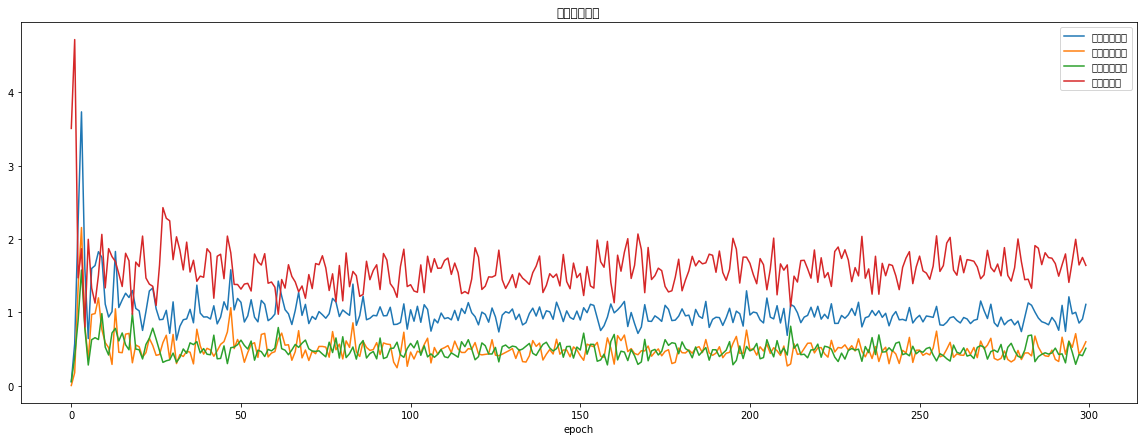

In [24]:
fig, ax = plt.subplots(figsize=(20,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='判别器总损失')
plt.plot(losses.T[1], label=u'判别真实损失')
plt.plot(losses.T[2], label=u'判别生成损失')
plt.plot(losses.T[3], label=u'生成器损失')
plt.title(u"对抗生成网络")
ax.set_xlabel('epoch')
plt.legend()

In [14]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [15]:
#samples是保存的结果 epoch是第多少次迭代
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

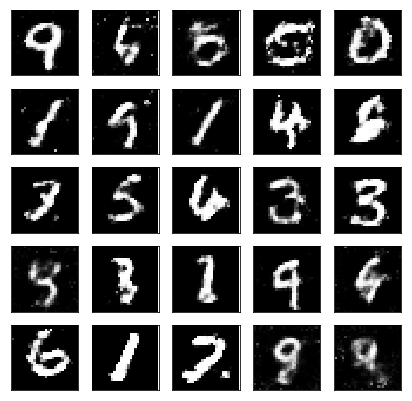

In [16]:
_ = view_samples(-1, samples) # 显示最终的生成结果

In [17]:
# 指定要查看的轮次
epoch_idx = [10, 30, 60, 90, 120, 150, 180, 210, 240, 290] 
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

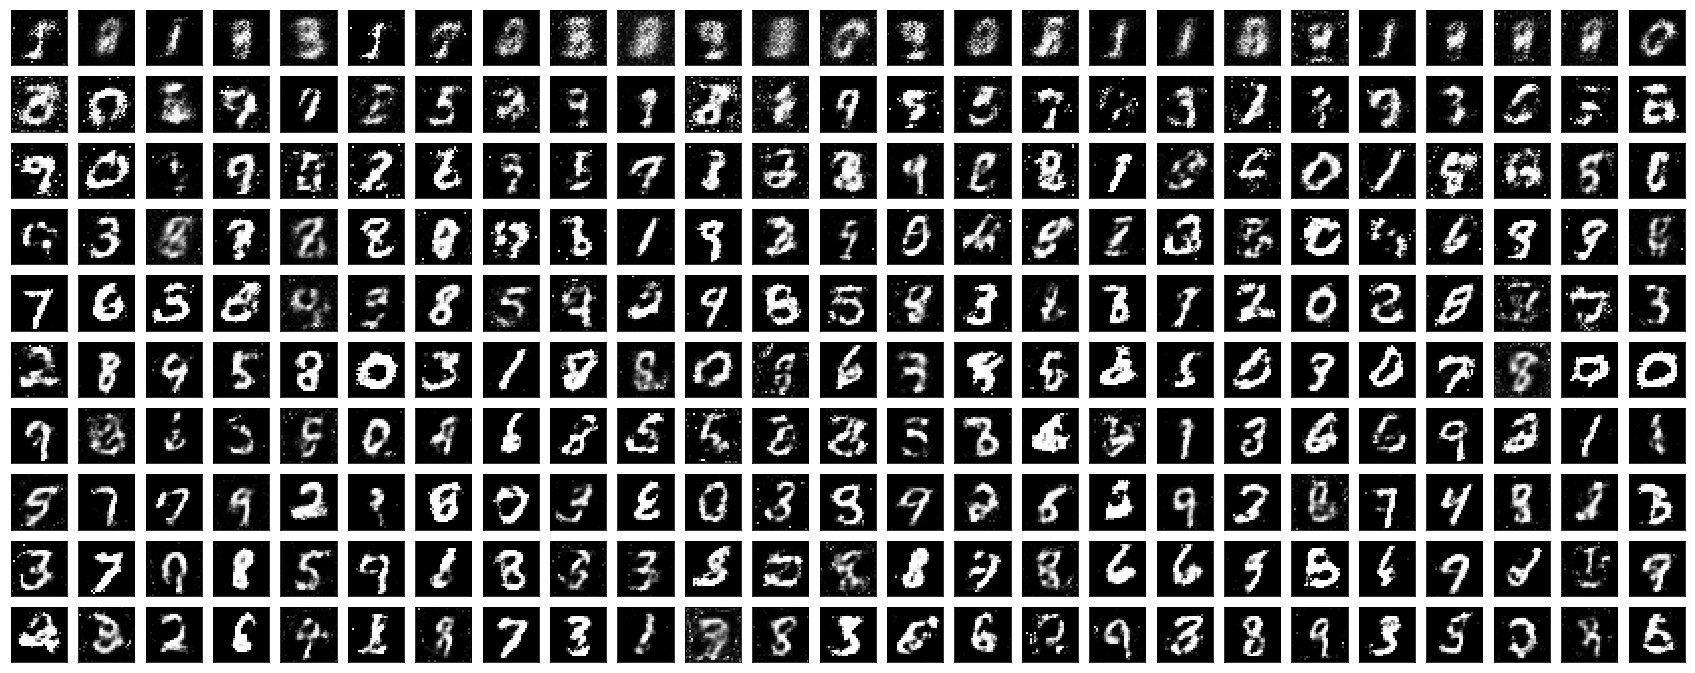

In [18]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [19]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})



INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


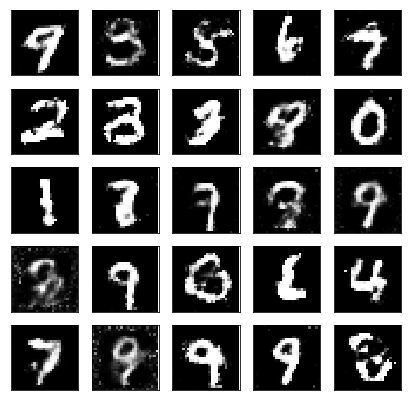

In [20]:
_ = view_samples(0, [gen_samples])